In [20]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.3"

# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
### TENSORS AND OPERATIONS ###

In [11]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]]) # matrix
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [12]:
t.shape

TensorShape([2, 3])

In [13]:
t.dtype

tf.float32

In [8]:
tf.constant(42) # scalar

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [14]:
# `tf.Tensor` values are immutable
# If we want to use tensors to implement weights in a neural netowork, we need to use `tf.Variable`
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [15]:
# ...

In [16]:
### CUSTOMIZING MODELS AND TRAINING ALGORITHMS ###

In [17]:
## CUSTOM LOSS FUNCTIONS ##

In [18]:
# Let's start by loading and preparing the California housing dataset.
# We first load it, then split it into a training set, a validation set and a test set, and finally we scale it

from sklearn.datasets        import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)

In [19]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

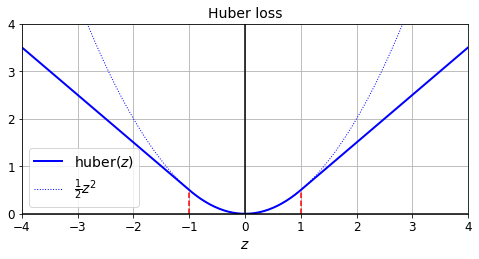

In [20]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [21]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal", input_shape=input_shape),
    keras.layers.Dense(1),
])

In [23]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [24]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 4ms/step - loss: 0.6235 - mae: 0.9953 - val_loss: 0.2862 - val_mae: 0.5866
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2197 - mae: 0.5177 - val_loss: 0.2382 - val_mae: 0.5281


In [25]:
## Saving/Loading Models with Custom Objects ##

In [26]:
model.save("models/deep/model_with_a_custom_loss.h5")

In [28]:
model = keras.models.load_model("models/deep/model_with_a_custom_loss.h5", custom_objects={"huber_fn": huber_fn})

In [29]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2054 - mean_absolute_error: 0.4982 - val_loss: 0.2209 - val_mean_absolute_error: 0.5050
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1999 - mean_absolute_error: 0.4900 - val_loss: 0.2127 - val_mean_absolute_error: 0.4986


In [30]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [31]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [33]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2226 - mae: 0.4892 - val_loss: 0.2540 - val_mae: 0.4907
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2184 - mae: 0.4844 - val_loss: 0.2372 - val_mae: 0.4879


In [34]:
# Unfortunately, when you save the model, the threshold will not be saved
model.save("models/deep/model_with_a_custom_loss_threshold_2.h5")

In [35]:
model = keras.models.load_model("models/deep/model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [36]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2147 - mean_absolute_error: 0.4800 - val_loss: 0.2133 - val_mean_absolute_error: 0.4654
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2119 - mean_absolute_error: 0.4762 - val_loss: 0.1992 - val_mean_absolute_error: 0.4643


In [37]:
# You can solve this by creating a subclass of the keras.losses.Loss class,
# and then implementing its get_config() method

In [43]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
        
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [47]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal", input_shape=input_shape),
    keras.layers.Dense(1),
])

In [48]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [49]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 4ms/step - loss: 0.7095 - mae: 0.8863 - val_loss: 0.3378 - val_mae: 0.5485
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2416 - mae: 0.5083 - val_loss: 0.2660 - val_mae: 0.5089


In [50]:
model.save("models/deep/model_with_a_custom_loss_class.h5")

In [51]:
model = keras.models.load_model("models/deep/model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

In [52]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2286 - mean_absolute_error: 0.4970 - val_loss: 0.2120 - val_mean_absolute_error: 0.4723
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2216 - mean_absolute_error: 0.4904 - val_loss: 0.2045 - val_mean_absolute_error: 0.4725


In [53]:
model.loss.threshold

2.0

In [54]:
## Other Custom Functions ##

In [55]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [56]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [57]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [58]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [59]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal", input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [60]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [61]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 4ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 1.4399 - val_mae: 0.5137


In [62]:
model.save("models/deep/model_with_many_custom_parts.h5")

In [63]:
model = keras.models.load_model(
    "models/deep/model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

In [64]:
## Custom Metrics ##

In [65]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [66]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal", input_shape=input_shape),
    keras.layers.Dense(1),
])

In [67]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [68]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 2.0982 - huber_fn: 0.9192
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.6052 - huber_fn: 0.2733


In [71]:
## Streaming Metrics ##

In [72]:
# Create a `Precision` object
precision = keras.metrics.Precision()

# Pass the labels and predictions for the first batch
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])
# 0.8 (80% precision)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [73]:
# Pass the labels and predictions for the second batch
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])
# 0.5 (50% precision)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [74]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [75]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [76]:
precision.reset_states()

In [77]:
# If you need to create such a streaming metric, create a subclass of the keras.metrics.Metric class.
# Here is a simple example that keeps track of the total Huber loss and the number of instances seen so far.
# When asked for the result, it returns the ratio, which is simply the mean Huber loss

In [78]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
        
    def result(self):
        return self.total / self.count # mean Huber metric
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [79]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [80]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [81]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [82]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

In [83]:
## Custom Layers ##

In [84]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [85]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

In [86]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [87]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])

model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 4ms/step - loss: 1.0631 - val_loss: 0.4457
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4562 - val_loss: 0.3798
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4029 - val_loss: 0.3548
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3851 - val_loss: 0.3464
Epoch 5/5
162/162 [==============================] - 0s 2ms/step - loss: 0.3586


0.3586340844631195

In [89]:
# Custom layer
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units      = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units, "activation": keras.activations.serialize(self.activation)}

In [90]:
# e.g.: `Concatenate` layer from Keras
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape) # Debugging of custom layer
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [91]:
# Let's create a layer that adds Gaussian noise during training
# (for regularization), but does nothing during testing
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [92]:
## CUSTOM MODELS ##

In [93]:
X_new_scaled = X_test_scaled

In [95]:
# file:///C:/Users/Iulian/Desktop/ML/Hands-on%20Machine%20Learning.pdf#page=425&zoom=100,0,72
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu", kernel_initializer="he_normal") for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [96]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        # Input
        self.hidden1 = keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal")
        # Hidden
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        # Output
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [97]:
## CUSTOM TRAINING LOOPS ##

In [98]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [100]:
# First, let’s build a simple model. No need to compile it, since we will handle the training loop manually
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal", kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [33]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [34]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result()) for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics, end=end)

In [105]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [106]:
n_epochs   = 5
batch_size = 32
n_steps    = len(X_train) // batch_size
optimizer  = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn    = keras.losses.mean_squared_error
mean_loss  = keras.metrics.Mean()
metrics    = [keras.metrics.MeanAbsoluteError()]

In [107]:
# Now we are ready to build the custom loop

In [108]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        
        with tf.GradientTape() as tape:
            y_pred    = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss      = tf.add_n([main_loss] + model.losses)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
                
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
        
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11610/11610 - mean: 1.3955 - mean_absolute_error: 0.5722
Epoch 2/5
11610/11610 - mean: 0.6774 - mean_absolute_error: 0.5280
Epoch 3/5
11610/11610 - mean: 0.6351 - mean_absolute_error: 0.5177
Epoch 4/5
11610/11610 - mean: 0.6384 - mean_absolute_error: 0.5181
Epoch 5/5
11610/11610 - mean: 0.6440 - mean_absolute_error: 0.5222


In [109]:
### TENSORFLOW FUNCTIONS AND GRAPHS ###

In [111]:
# When a python function is complex, we can transform
# it into a tf function by adding the `@tf.function` decorator

In [1]:
### EXERCISES ###

In [2]:
# 1. How would you describe TensorFlow in a short sentence? What are its main features?
# Can you name other popular Deep Learning libraries?

# TensorFlow is an open-source library for numerical computation, particularly
# well suited and fine-tuned for large-scale Machine Learning. Its core is similar to
# NumPy, but it also features GPU support, support for distributed computing,
# computation graph analysis and optimization capabilities (with a portable graph
# format that allows you to train a TensorFlow model in one environment and run
# it in another), an optimization API based on reverse-mode autodiff, and several
# powerful APIs such as tf.keras, tf.data, tf.image, tf.signal, and more. Other popu‐
# lar Deep Learning libraries include PyTorch, MXNet, Microsoft Cognitive Tool‐
# kit, Theano, Caffe2, and Chainer.

In [3]:
# 2. Is TensorFlow a drop-in replacement for NumPy? What are the main differences between the two?

# Although TensorFlow offers most of the functionalities provided by NumPy, it is
# not a drop-in replacement, for a few reasons. First, the names of the functions are
# not always the same (for example, tf.reduce_sum() versus np.sum()). Second,
# some functions do not behave in exactly the same way (for example, tf.trans
# pose() creates a transposed copy of a tensor, while NumPy’s T attribute creates a
# transposed view, without actually copying any data). Lastly, NumPy arrays are
# mutable, while TensorFlow tensors are not (but you can use a tf.Variable if you
# need a mutable object).

In [7]:
# 3. Do you get the same result with tf.range(10) and tf.constant(np.arange(10))?

# Both tf.range(10) and tf.constant(np.arange(10)) return a onedimensional tensor containing the integers 0 to 9.
# However, the former uses 32-bit integers while the latter uses 64-bit integers. Indeed, TensorFlow defaults to
# 32 bits, while NumPy defaults to 64 bits.

In [8]:
# 4. Can you name six other data structures available in TensorFlow, beyond regular tensors?

# Beyond regular tensors, TensorFlow offers several other data structures, includ‐
# ing sparse tensors, tensor arrays, ragged tensors, queues, string tensors, and sets.
# The last two are actually represented as regular tensors, but TensorFlow provides
# special functions to manipulate them (in tf.strings and tf.sets)

In [9]:
# 5. A custom loss function can be defined by writing a function or by subclassing the
# keras.losses.Loss class. When would you use each option?

# When you want to define a custom loss function, in general you can just imple‐
# ment it as a regular Python function. However, if your custom loss function must
# support some hyperparameters (or any other state), then you should subclass the
# keras.losses.Loss class and implement the __init__() and call() methods. If
# you want the loss function’s hyperparameters to be saved along with the model,
# then you must also implement the get_config() method.

In [10]:
# 6. Similarly, a custom metric can be defined in a function or a subclass of
# keras.metrics.Metric. When would you use each option?

# Much like custom loss functions, most metrics can be defined as regular Python
# functions. But if you want your custom metric to support some hyperparameters
# (or any other state), then you should subclass the keras.metrics.Metric class.
# Moreover, if computing the metric over a whole epoch is not equivalent to com‐
# puting the mean metric over all batches in that epoch (e.g., as for the precision
# and recall metrics), then you should subclass the keras.metrics.Metric class
# and implement the __init__(), update_state(), and result() methods to keep
# track of a running metric during each epoch. You should also implement the
# reset_states() method unless all it needs to do is reset all variables to 0.0. If
# you want the state to be saved along with the model, then you should implement
# the get_config() method as well

In [11]:
# 7. When should you create a custom layer versus a custom model?

# You should distinguish the internal components of your model (i.e., layers or
# reusable blocks of layers) from the model itself (i.e., the object you will train).
# The former should subclass the keras.layers.Layer class, while the latter
# should subclass the keras.models.Model class

In [12]:
# 8. What are some use cases that require writing your own custom training loop?

# Writing your own custom training loop is fairly advanced, so you should only do
# it if you really need to. Keras provides several tools to customize training without
# having to write a custom training loop: callbacks, custom regularizers, custom
# constraints, custom losses, and so on. You should use these instead of writing a
# custom training loop whenever possible: writing a custom training loop is more
# error-prone, and it will be harder to reuse the custom code you write. However,
# in some cases writing a custom training loop is necessary—for example, if you
# want to use different optimizers for different parts of your neural network, like in
# the Wide & Deep paper. A custom training loop can also be useful when debug‐
# ging, or when trying to understand exactly how training works

In [13]:
# 9. Can custom Keras components contain arbitrary Python code, or must they be convertible to TF Functions?

# Custom Keras components should be convertible to TF Functions, which means
# they should stick to TF operations as much as possible and respect all the rules
# listed in “TF Function Rules” on page 409. If you absolutely need to include arbi‐
# trary Python code in a custom component, you can either wrap it in a
# tf.py_function() operation (but this will reduce performance and limit your
# model’s portability) or set dynamic=True when creating the custom layer or
# model (or set run_eagerly=True when calling the model’s compile() method).

In [14]:
# 10. What are the main rules to respect if you want a function to be convertible to a TF Function?

# Please refer to “TF Function Rules” on page 409 for the list of rules to respect when creating a TF Function.

In [16]:
# 11. When would you need to create a dynamic Keras model? How do you do that?
# Why not make all your models dynamic?

# Creating a dynamic Keras model can be useful for debugging, as it will not com‐
# pile any custom component to a TF Function, and you can use any Python
# debugger to debug your code. It can also be useful if you want to include arbi‐
# trary Python code in your model (or in your training code), including calls to
# external libraries. To make a model dynamic, you must set dynamic=True when
# creating it. Alternatively, you can set run_eagerly=True when calling the model’s
# compile() method. Making a model dynamic prevents Keras from using any of
# TensorFlow’s graph features, so it will slow down training and inference, and you
# will not have the possibility to export the computation graph, which will limit
# your model’s portability.

In [17]:
# 12. Implement a custom layer that performs Layer Normalization (we will use this type of layer in Chapter 15):

# a. The build() method should define two trainable weights α and β, both of
# shape input_shape[-1:] and data type tf.float32. α should be initialized
# with 1s, and β with 0s.

# b. The call() method should compute the mean μ and standard deviation σ of
# each instance’s features. For this, you can use tf.nn.moments(inputs,
# axes=-1, keepdims=True), which returns the mean μ and the variance σ^2 of
# all instances (compute the square root of the variance to get the standard
# deviation). Then the function should compute and return α⊗(X - μ)/(σ + ε) +
# β, where ⊗ represents itemwise multiplication (*) and ε is a smoothing term
# (small constant to avoid division by zero, e.g., 0.001).

# c. Ensure that your custom layer produces the same (or very nearly the same)
# output as the keras.layers.LayerNormalization layer

In [21]:
class LayerNormalization(keras.layers.Layer):
    def __init__(self, eps=0.001, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def build(self, batch_input_shape):
        self.alpha = self.add_weight(
            name="alpha", shape=batch_input_shape[-1:],
            initializer="ones")
        self.beta = self.add_weight(
            name="beta", shape=batch_input_shape[-1:],
            initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha * (X - mean) / (tf.sqrt(variance + self.eps)) + self.beta

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "eps": self.eps}

In [24]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

X = X_train.astype(np.float32)

In [25]:
custom_layer_norm = LayerNormalization()
keras_layer_norm  = keras.layers.LayerNormalization()

tf.reduce_mean(keras.losses.mean_absolute_error( keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=7.838749e-08>

In [26]:
# 13. Train a model using a custom training loop to tackle the Fashion MNIST dataset
# (see Chapter 10).

# a. Display the epoch, iteration, mean training loss, and mean accuracy over each
# epoch (updated at each iteration), as well as the validation loss and accuracy at
# the end of each epoch.

# b. Try using a different optimizer with a different learning rate for the
# upper layers and the lower layers.

In [27]:
# a.
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

In [28]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [37]:
n_epochs   = 1
batch_size = 32
n_steps    = len(X_train) // batch_size
optimizer  = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn    = keras.losses.sparse_categorical_crossentropy
mean_loss  = keras.metrics.Mean()
metrics    = [keras.metrics.SparseCategoricalAccuracy()]

In [38]:
from tqdm import trange
from collections import OrderedDict

with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

Epoch 1/1:   3%|▎         | 59/1718 [00:01<00:42, 39.19it/s, loss=0.449, sparse_categorical_accuracy=0.842]


Epoch 1/1:   7%|▋         | 118/1718 [00:03<00:38, 41.71it/s, loss=0.439, sparse_categorical_accuracy=0.843]


Epoch 1/1:  10%|█         | 178/1718 [00:04<00:35, 43.52it/s, loss=0.462, sparse_categorical_accuracy=0.837]


Epoch 1/1:  14%|█▍        | 238/1718 [00:05<00:32, 44.91it/s, loss=0.466, sparse_categorical_accuracy=0.836]


Epoch 1/1:  17%|█▋        | 300/1718 [00:07<00:29, 48.31it/s, loss=0.459, sparse_categorical_accuracy=0.838]


Epoch 1/1:  21%|██        | 361/1718 [00:08<00:27, 49.64it/s, loss=0.458, sparse_categorical_accuracy=0.84]


Epoch 1/1:  25%|██▍       | 424/1718 [00:09<00:25, 49.95it/s, loss=0.46, sparse_categorical_accuracy=0.84] 


Epoch 1/1:  29%|██▊       | 490/1718 [00:10<00:24, 50.79it/s, loss=0.451, sparse_categorical_accuracy=0.842]


Epoch 1/1:  32%|███▏      | 550/1718 [00:12<00:23, 50.14it/s, loss=0.447, sparse_categorical_accuracy=0.844]


Epoch 1/1:  36%|███▌      | 613/1718 [00:13<00:23, 47.86it/s, loss=0.448, sparse_categorical_accuracy=0.843]


Epoch 1/1:  39%|███▉      | 672/1718 [00:14<00:22, 46.38it/s, loss=0.447, sparse_categorical_accuracy=0.844]


Epoch 1/1:  43%|████▎     | 736/1718 [00:15<00:18, 51.89it/s, loss=0.445, sparse_categorical_accuracy=0.844]


Epoch 1/1:  47%|████▋     | 801/1718 [00:17<00:18, 50.93it/s, loss=0.448, sparse_categorical_accuracy=0.843]


Epoch 1/1:  50%|█████     | 860/1718 [00:18<00:16, 50.57it/s, loss=0.446, sparse_categorical_accuracy=0.843]


Epoch 1/1:  54%|█████▍    | 926/1718 [00:19<00:15, 52.33it/s, loss=0.443, sparse_categorical_accuracy=0.844]


Epoch 1/1:  57%|█████▋    | 984/1718 [00:20<00:14, 50.45it/s, loss=0.442, sparse_categorical_accuracy=0.845]


Epoch 1/1:  61%|██████    | 1047/1718 [00:22<00:13, 48.37it/s, loss=0.443, sparse_categorical_accuracy=0.844]


Epoch 1/1:  64%|██████▍   | 1106/1718 [00:23<00:14, 43.24it/s, loss=0.442, sparse_categorical_accuracy=0.844]


Epoch 1/1:  68%|██████▊   | 1166/1718 [00:24<00:11, 48.29it/s, loss=0.442, sparse_categorical_accuracy=0.844]


Epoch 1/1:  72%|███████▏  | 1230/1718 [00:26<00:09, 50.82it/s, loss=0.44, sparse_categorical_accuracy=0.845]


Epoch 1/1:  75%|███████▌  | 1292/1718 [00:27<00:09, 45.08it/s, loss=0.439, sparse_categorical_accuracy=0.845]


Epoch 1/1:  79%|███████▊  | 1350/1718 [00:28<00:08, 44.52it/s, loss=0.437, sparse_categorical_accuracy=0.846]


Epoch 1/1:  82%|████████▏ | 1411/1718 [00:29<00:06, 48.71it/s, loss=0.435, sparse_categorical_accuracy=0.846]


Epoch 1/1:  86%|████████▌ | 1473/1718 [00:31<00:04, 49.89it/s, loss=0.434, sparse_categorical_accuracy=0.847]


Epoch 1/1:  89%|████████▉ | 1537/1718 [00:32<00:03, 48.29it/s, loss=0.434, sparse_categorical_accuracy=0.847]


Epoch 1/1:  93%|█████████▎| 1600/1718 [00:33<00:02, 53.20it/s, loss=0.431, sparse_categorical_accuracy=0.847]


Epoch 1/1:  97%|█████████▋| 1661/1718 [00:35<00:01, 51.70it/s, loss=0.431, sparse_categorical_accuracy=0.848]


All epochs: 100%|██████████| 1/1 [00:36<00:00, 36.02s/it]


In [40]:
# b.
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [41]:
lower_layers = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
])
upper_layers = keras.models.Sequential([
    keras.layers.Dense(10, activation="softmax"),
])
model = keras.models.Sequential([
    lower_layers, upper_layers
])

In [42]:
lower_optimizer = keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = keras.optimizers.Nadam(learning_rate=1e-3)

In [45]:
n_epochs   = 1
batch_size = 32
n_steps    = len(X_train) // batch_size
loss_fn    = keras.losses.sparse_categorical_crossentropy
mean_loss  = keras.metrics.Mean()
metrics    = [keras.metrics.SparseCategoricalAccuracy()]

In [46]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

Epoch 1/1:   3%|▎         | 56/1718 [00:01<00:43, 38.44it/s, loss=2.26, sparse_categorical_accuracy=0.133]


Epoch 1/1:   7%|▋         | 117/1718 [00:03<00:45, 34.99it/s, loss=2.12, sparse_categorical_accuracy=0.234]


Epoch 1/1:  10%|█         | 180/1718 [00:04<00:38, 40.09it/s, loss=1.99, sparse_categorical_accuracy=0.337]


Epoch 1/1:  14%|█▍        | 238/1718 [00:06<00:30, 48.11it/s, loss=1.89, sparse_categorical_accuracy=0.401]


Epoch 1/1:  18%|█▊        | 303/1718 [00:07<00:34, 40.74it/s, loss=1.8, sparse_categorical_accuracy=0.446]


Epoch 1/1:  21%|██        | 361/1718 [00:09<00:36, 37.27it/s, loss=1.73, sparse_categorical_accuracy=0.481]


Epoch 1/1:  25%|██▍       | 421/1718 [00:10<00:26, 49.88it/s, loss=1.66, sparse_categorical_accuracy=0.509]


Epoch 1/1:  28%|██▊       | 489/1718 [00:11<00:30, 40.94it/s, loss=1.6, sparse_categorical_accuracy=0.531]


Epoch 1/1:  32%|███▏      | 546/1718 [00:13<00:20, 56.90it/s, loss=1.54, sparse_categorical_accuracy=0.551]


Epoch 1/1:  36%|███▌      | 612/1718 [00:14<00:23, 47.95it/s, loss=1.49, sparse_categorical_accuracy=0.565]


Epoch 1/1:  39%|███▉      | 673/1718 [00:15<00:26, 38.92it/s, loss=1.45, sparse_categorical_accuracy=0.578]


Epoch 1/1:  43%|████▎     | 736/1718 [00:17<00:27, 36.15it/s, loss=1.41, sparse_categorical_accuracy=0.59]


Epoch 1/1:  46%|████▋     | 798/1718 [00:18<00:22, 40.37it/s, loss=1.37, sparse_categorical_accuracy=0.6]


Epoch 1/1:  50%|████▉     | 857/1718 [00:19<00:15, 57.30it/s, loss=1.34, sparse_categorical_accuracy=0.609]


Epoch 1/1:  54%|█████▍    | 925/1718 [00:20<00:13, 57.88it/s, loss=1.31, sparse_categorical_accuracy=0.617]


Epoch 1/1:  57%|█████▋    | 987/1718 [00:21<00:12, 56.68it/s, loss=1.28, sparse_categorical_accuracy=0.625]


Epoch 1/1:  61%|██████    | 1049/1718 [00:22<00:11, 59.18it/s, loss=1.25, sparse_categorical_accuracy=0.631]


Epoch 1/1:  65%|██████▍   | 1113/1718 [00:24<00:11, 50.78it/s, loss=1.23, sparse_categorical_accuracy=0.638]


Epoch 1/1:  68%|██████▊   | 1174/1718 [00:25<00:09, 57.87it/s, loss=1.2, sparse_categorical_accuracy=0.645]


Epoch 1/1:  72%|███████▏  | 1236/1718 [00:26<00:09, 49.99it/s, loss=1.18, sparse_categorical_accuracy=0.65]


Epoch 1/1:  76%|███████▌  | 1303/1718 [00:27<00:08, 48.19it/s, loss=1.16, sparse_categorical_accuracy=0.655]


Epoch 1/1:  79%|███████▉  | 1361/1718 [00:29<00:06, 54.19it/s, loss=1.14, sparse_categorical_accuracy=0.659]


Epoch 1/1:  83%|████████▎ | 1422/1718 [00:30<00:07, 42.19it/s, loss=1.13, sparse_categorical_accuracy=0.664]


Epoch 1/1:  86%|████████▋ | 1485/1718 [00:31<00:05, 40.39it/s, loss=1.11, sparse_categorical_accuracy=0.667]


Epoch 1/1:  90%|████████▉ | 1545/1718 [00:33<00:03, 43.61it/s, loss=1.1, sparse_categorical_accuracy=0.671]


Epoch 1/1:  94%|█████████▎| 1610/1718 [00:34<00:02, 42.50it/s, loss=1.08, sparse_categorical_accuracy=0.674]


Epoch 1/1:  97%|█████████▋| 1669/1718 [00:36<00:01, 44.64it/s, loss=1.07, sparse_categorical_accuracy=0.677]


All epochs: 100%|██████████| 1/1 [00:37<00:00, 37.20s/it]
